In [2]:
# Cell 1: Install Custom Libraries

import subprocess
import sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-U", "google-generativeai", "segment-anything", "transformers", "lightgbm"])
print("Custom libraries installed successfully.")

Custom libraries installed successfully.


In [3]:
# Cell 2: Imports

import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully")

All libraries imported successfully


In [4]:
# Cell 3: Configuration

# Set to False to skip making API calls and only use the existing VLM cache
RUN_VLM_EXTRACTION = True
# Set to False to skip running the slow SAM model and only use the existing programmatic cache
RUN_PROGRAMMATIC_EXTRACTION = True

print("Control Flags:")
print(f"Run VLM Extraction: {RUN_VLM_EXTRACTION}")
print(f"Run Programmatic Extraction: {RUN_PROGRAMMATIC_EXTRACTION}")

# Kaggle environment configuration
DATA_DIR = '/kaggle/input/birds-vs-drone-dataset/BirdVsDrone'
VLM_CACHE_FILE = 'vlm_cache.csv'
PROGRAMMATIC_CACHE_FILE = 'programmatic_cache.csv'
CLASS_NAMES = ['Birds', 'Drones']

# Controls the fraction of the dataset to be processed
DATA_PERCENTAGE = 1.0

print("Running in Kaggle environment")
print(f"Data directory: {DATA_DIR}")
print(f"Class names: {CLASS_NAMES}")
print(f"Data percentage to process: {DATA_PERCENTAGE * 100}%")

# Verify data directory exists
if not os.path.exists(DATA_DIR):
    print(f"Warning: Data directory does not exist: {DATA_DIR}")
    print("Please ensure the dataset is properly placed in the expected location")
else:
    print(f"Data directory found: {DATA_DIR}")

Control Flags:
Run VLM Extraction: True
Run Programmatic Extraction: True
Running in Kaggle environment
Data directory: /kaggle/input/birds-vs-drone-dataset/BirdVsDrone
Class names: ['Birds', 'Drones']
Data percentage to process: 100.0%
Data directory found: /kaggle/input/birds-vs-drone-dataset/BirdVsDrone


Checking dataset structure:
 Birds: 400 images found
 Drones: 428 images found
Birds sample 1: singleBirdinsky316.jpeg - Shape: (225, 224, 3)
Birds sample 2: singleBirdinsky22.jpeg - Shape: (183, 275, 3)
Birds sample 3: singleBirdinsky280.jpeg - Shape: (183, 275, 3)
Drones sample 1: 266.JPEG - Shape: (738, 1280, 3)
Drones sample 2: 14.JPEG - Shape: (1501, 2668, 3)
Drones sample 3: singleDronesinsky372.jpeg - Shape: (168, 300, 3)


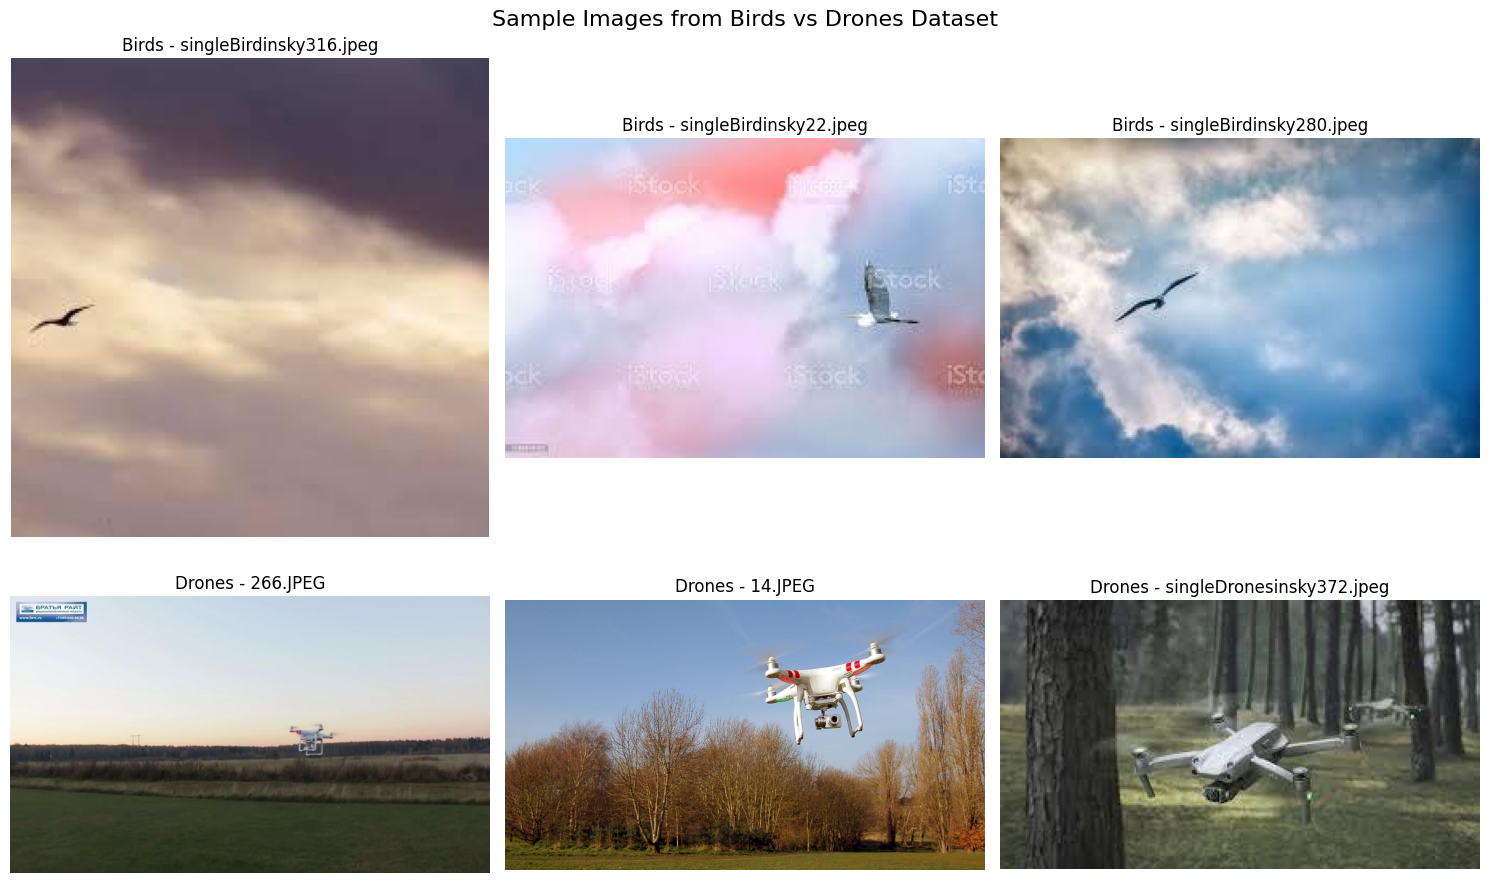

In [5]:
# Cell 4: Dataset Visualization

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_sample_images():
    """Display sample images from each class to verify dataset loading."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Sample Images from Birds vs Drones Dataset', fontsize=16)
    
    for i, class_name in enumerate(CLASS_NAMES):
        class_dir = os.path.join(DATA_DIR, class_name)
        if os.path.exists(class_dir):
            # Get first 3 images from each class
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))][:3]
            
            for j, img_file in enumerate(image_files):
                img_path = os.path.join(class_dir, img_file)
                try:
                    img = mpimg.imread(img_path)
                    axes[i, j].imshow(img)
                    axes[i, j].set_title(f'{class_name} - {img_file}')
                    axes[i, j].axis('off')
                    
                    # Print image info
                    print(f"{class_name} sample {j+1}: {img_file} - Shape: {img.shape}")
                    
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    axes[i, j].text(0.5, 0.5, f'Error loading\n{img_file}', 
                                   ha='center', va='center', transform=axes[i, j].transAxes)
                    axes[i, j].axis('off')
        else:
            print(f"Warning: Directory {class_dir} does not exist")
    
    plt.tight_layout()
    plt.show()

# Check if directories exist and show dataset structure
print("Checking dataset structure:")
for class_name in CLASS_NAMES:
    class_dir = os.path.join(DATA_DIR, class_name)
    if os.path.exists(class_dir):
        num_images = len([f for f in os.listdir(class_dir) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))])
        print(f" {class_name}: {num_images} images found")
    else:
        print(f" {class_name}: Directory not found at {class_dir}")

# Visualize sample images
visualize_sample_images()

In [6]:
# Cell 5: Configure Gemini API

import google.generativeai as genai
from PIL import Image
import json

# Import Kaggle's UserSecretsClient to securely access API keys
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    GEMINI_API_KEY = user_secrets.get_secret("GEMINI_API_KEY")
    print("Successfully retrieved Gemini API key from Kaggle Secrets")
except Exception as e:
    print(f"Warning: Could not retrieve API key from Kaggle Secrets: {e}")
    print("Please ensure you have added GEMINI_API_KEY to your Kaggle Secrets")
    GEMINI_API_KEY = None

# Configure the Gemini API
if GEMINI_API_KEY:
    genai.configure(api_key=GEMINI_API_KEY)
    print("Gemini API configured successfully")
else:
    print("Gemini API configuration failed - API key not available")

# Create a clear boolean flag for API availability
is_gemini_available = bool(GEMINI_API_KEY)
print(f"Gemini API available for this run: {is_gemini_available}")

Successfully retrieved Gemini API key from Kaggle Secrets
Gemini API configured successfully
Gemini API available for this run: True


In [7]:
# Cell 6: Define Real VLM Feature Extraction Function

import re
import time

def get_contextual_features_from_image(image_path):
    """
    Extract contextual features from an image using Google's Gemini Vision model.
    Returns a dictionary with time_of_day, weather_condition, and background_complexity.
    """
    
    # Define the structured prompt
    prompt = """
    Analyze this image and extract contextual information. Return ONLY a JSON object with the following structure:

    {
        "time_of_day": "one of: morning, afternoon, evening, dawn, dusk, night",
        "weather_condition": "one of: clear, cloudy, overcast, partly_cloudy, hazy, foggy",
        "background_complexity": "one of: low, medium, high"
    }

    Guidelines:
    - time_of_day: Based on lighting conditions and shadows
    - weather_condition: Based on sky appearance, visibility, and atmospheric conditions
    - background_complexity: low=simple sky/few objects, medium=some details/moderate clutter, high=busy/complex scene

    Return only the JSON object, no additional text or explanation.
    """
    
    try:
        # Load the image
        image = Image.open(image_path)
        
        # Instantiate the Gemini model
        model = genai.GenerativeModel('gemini-1.5-flash')
        
        # Generate content with the image and prompt
        response = model.generate_content([prompt, image])
        
        # Extract and clean the response text
        response_text = response.text.strip()
        
        # Use regex to extract only the JSON part between curly braces
        json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
        if json_match:
            json_text = json_match.group(0)
        else:
            # Fallback to original response if no JSON structure found
            json_text = response_text
        
        # Parse the JSON response
        contextual_features = json.loads(json_text)
        
        # Validate that all required keys are present
        required_keys = ['time_of_day', 'weather_condition', 'background_complexity']
        for key in required_keys:
            if key not in contextual_features:
                print(f"Warning: Missing key '{key}' in API response for {image_path}")
                contextual_features[key] = None
        
        # Rate limiting - sleep to respect API limits
        time.sleep(1.5)
        
        return contextual_features
        
    except json.JSONDecodeError as e:
        print(f"JSON parsing error for {image_path}: {e}")
        print(f"Raw response: {response_text if 'response_text' in locals() else 'No response'}")
        print(f"Extracted JSON: {json_text if 'json_text' in locals() else 'No JSON extracted'}")
        return {
            'time_of_day': None,
            'weather_condition': None,
            'background_complexity': None
        }
    
    except Exception as e:
        print(f"API call error for {image_path}: {e}")
        return {
            'time_of_day': None,
            'weather_condition': None,
            'background_complexity': None
        }

print("Real VLM function with Gemini API defined successfully")

Real VLM function with Gemini API defined successfully


In [9]:
# Cell 6.5: Setup Segment Anything Model (SAM)

import subprocess
import sys

# Install SAM dependencies
print("Installing SAM dependencies...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "segment-anything", "transformers"])

from transformers import SamModel, SamProcessor
import torch

# Load pre-trained SAM model and processor
print("Loading SAM model...")
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
sam_model = SamModel.from_pretrained("facebook/sam-vit-base")

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_model.to(device)
sam_model.eval()

print(f"SAM model loaded successfully on {device}")

Installing SAM dependencies...
Loading SAM model...
SAM model loaded successfully on cpu


In [10]:
# Cell 7: Test the New Function

print("Testing the Gemini API function...")

# Find a sample image path from the dataset
sample_image_path = None
for class_name in CLASS_NAMES:
    class_dir = os.path.join(DATA_DIR, class_name)
    if os.path.exists(class_dir):
        image_files = [f for f in os.listdir(class_dir) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]
        if image_files:
            sample_image_path = os.path.join(class_dir, image_files[0])
            break

if sample_image_path and GEMINI_API_KEY:
    print(f"Testing with sample image: {sample_image_path}")
    
    # Test the function
    test_result = get_contextual_features_from_image(sample_image_path)
    
    print("Test Results:")
    print(f"Time of day: {test_result.get('time_of_day')}")
    print(f"Weather condition: {test_result.get('weather_condition')}")
    print(f"Background complexity: {test_result.get('background_complexity')}")
    
    if any(value is not None for value in test_result.values()):
        print(" Gemini API function working correctly")
    else:
        print(" API function returned None values - check API configuration")
        
elif not GEMINI_API_KEY:
    print(" Cannot test function - Gemini API key not available")
    
elif not sample_image_path:
    print(" Cannot test function - no sample images found in dataset")
    
else:
    print(" Function defined but not tested - will use in main processing loop")

Testing the Gemini API function...
Testing with sample image: /kaggle/input/birds-vs-drone-dataset/BirdVsDrone/Birds/singleBirdinsky316.jpeg
Test Results:
Time of day: dusk
Weather condition: cloudy
Background complexity: low
 Gemini API function working correctly


In [11]:
# Cell 8: Programmatic Feature Extraction Functions

def calculate_shape_features(contour):
    """Calculate shape-based features from contour."""
    try:
        # Calculate solidity (ratio of contour area to convex hull area)
        area = cv2.contourArea(contour)
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0
        
        # Calculate aspect ratio from bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h if h > 0 else 0
        
        return solidity, aspect_ratio
    except Exception as e:
        return 0.0, 0.0

def calculate_texture_features(roi):
    """Calculate texture contrast using GLCM."""
    try:
        # Convert to grayscale if needed
        if len(roi.shape) == 3:
            gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        else:
            gray_roi = roi
        
        # Resize ROI if too small
        if gray_roi.shape[0] < 10 or gray_roi.shape[1] < 10:
            gray_roi = cv2.resize(gray_roi, (50, 50))
        
        # Calculate GLCM
        glcm = graycomatrix(gray_roi, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        
        return contrast
    except Exception as e:
        return 0.0

def get_dominant_color(roi):
    """Extract dominant color using KMeans clustering."""
    try:
        # Reshape image to be a list of pixels
        data = roi.reshape((-1, 3))
        data = np.float32(data)
        
        # Apply KMeans
        k = 3  # Number of clusters
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
        _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        
        # Find the most common cluster
        unique, counts = np.unique(labels, return_counts=True)
        dominant_cluster = unique[np.argmax(counts)]
        dominant_color = centers[dominant_cluster]
        
        # Convert to RGB format and create color description
        r, g, b = dominant_color.astype(int)
        
        # Simple color categorization
        if r > 150 and g > 150 and b > 150:
            color_name = "light"
        elif r < 100 and g < 100 and b < 100:
            color_name = "dark"
        elif r > g and r > b:
            color_name = "reddish"
        elif g > r and g > b:
            color_name = "greenish"
        elif b > r and b > g:
            color_name = "bluish"
        else:
            color_name = "mixed"
            
        return color_name
    except Exception as e:
        return "unknown"

def has_motion_blur(roi):
    """Detect motion blur using Laplacian variance."""
    try:
        # Convert to grayscale if needed
        if len(roi.shape) == 3:
            gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        else:
            gray_roi = roi
        
        # Calculate Laplacian variance
        laplacian_var = cv2.Laplacian(gray_roi, cv2.CV_64F).var()
        
        # Threshold for blur detection (lower values indicate more blur)
        blur_threshold = 100
        return laplacian_var < blur_threshold
    except Exception as e:
        return False

def extract_programmatic_features(image_path):
    """
    Main wrapper function for programmatic feature extraction.
    Uses Segment Anything Model (SAM) for advanced object segmentation.
    """
    try:
        # Read image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")
        
        # Convert BGR to RGB for SAM
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Prepare image for SAM
        inputs = sam_processor(image_rgb, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Generate segmentation masks using SAM
        with torch.no_grad():
            outputs = sam_model(**inputs)
        
        # Get the masks and their scores
        masks = outputs.pred_masks.squeeze()
        scores = outputs.iou_scores.squeeze()
        
        # Select the best mask (highest IoU score)
        if len(scores) > 0:
            best_mask_idx = torch.argmax(scores).item()
            best_mask = masks[best_mask_idx].cpu().numpy()
            
            # Convert boolean mask to contour
            best_mask_uint8 = (best_mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(best_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Find the largest contour from the mask
            if contours:
                contour = max(contours, key=cv2.contourArea)
                
                # Filter by minimum area (at least 1% of image)
                min_area = image.shape[0] * image.shape[1] * 0.01
                if cv2.contourArea(contour) > min_area:
                    # Extract ROI using the contour
                    x, y, w, h = cv2.boundingRect(contour)
                    roi = image[y:y+h, x:x+w]
                    
                    # Calculate features using the high-quality contour
                    object_solidity, object_aspect_ratio = calculate_shape_features(contour)
                    texture_contrast = calculate_texture_features(roi)
                    dominant_object_color = get_dominant_color(roi)
                    motion_blur = has_motion_blur(roi)
                else:
                    # Contour too small, use default values
                    object_solidity = None
                    object_aspect_ratio = None
                    texture_contrast = None
                    dominant_object_color = None
                    motion_blur = None
            else:
                # No contours found, use default values
                object_solidity = None
                object_aspect_ratio = None
                texture_contrast = None
                dominant_object_color = None
                motion_blur = None
        else:
            # No masks generated, use default values
            object_solidity = None
            object_aspect_ratio = None
            texture_contrast = None
            dominant_object_color = None
            motion_blur = None
        
        return {
            'object_solidity': object_solidity,
            'object_aspect_ratio': object_aspect_ratio,
            'texture_contrast': texture_contrast,
            'dominant_object_color': dominant_object_color,
            'has_motion_blur': motion_blur
        }
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return {
            'object_solidity': None,
            'object_aspect_ratio': None,
            'texture_contrast': None,
            'dominant_object_color': None,
            'has_motion_blur': None
        }

print("All programmatic feature extraction functions defined successfully")

All programmatic feature extraction functions defined successfully


In [12]:
# New Assembler Cell: Data Gathering and Assembly

def create_worklists(is_gemini_available):
    """
    Create worklists for VLM and programmatic processing by comparing available images against existing caches.
    Returns vlm_worklist, programmatic_worklist.
    """
    
    # Define paths to search for cache files
    search_paths = ['/kaggle/working/', '/kaggle/input/']
    
    vlm_cache_files = []
    programmatic_cache_files = []
    
    # Find all relevant cache files
    for search_path in search_paths:
        if os.path.exists(search_path):
            for root, dirs, files in os.walk(search_path):
                for file in files:
                    if file == 'vlm_cache.csv':
                        vlm_cache_files.append(os.path.join(root, file))
                    elif file == 'programmatic_cache.csv':
                        programmatic_cache_files.append(os.path.join(root, file))
    
    print(f"Found {len(vlm_cache_files)} VLM cache files: {vlm_cache_files}")
    print(f"Found {len(programmatic_cache_files)} programmatic cache files: {programmatic_cache_files}")
    
    # Load and consolidate VLM cache files
    vlm_image_ids = set()
    for file_path in vlm_cache_files:
        try:
            df = pd.read_csv(file_path)
            vlm_image_ids.update(df['image_id'].tolist())
            print(f"Loaded VLM cache from {file_path}: {len(df)} entries")
        except Exception as e:
            print(f"Error loading VLM cache from {file_path}: {e}")
    
    print(f"Total unique VLM cached images: {len(vlm_image_ids)}")
    
    # Load and consolidate programmatic cache files
    programmatic_image_ids = set()
    for file_path in programmatic_cache_files:
        try:
            df = pd.read_csv(file_path)
            programmatic_image_ids.update(df['image_id'].tolist())
            print(f"Loaded programmatic cache from {file_path}: {len(df)} entries")
        except Exception as e:
            print(f"Error loading programmatic cache from {file_path}: {e}")
    
    print(f"Total unique programmatic cached images: {len(programmatic_image_ids)}")
    
    # Get list of all images that should be processed based on DATA_PERCENTAGE
    all_image_paths = []
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(DATA_DIR, class_name)
        if os.path.exists(class_dir):
            class_image_files = []
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.webp')):
                    file_path = os.path.join(class_dir, filename)
                    class_image_files.append((file_path, class_name, filename))
            
            num_samples = int(len(class_image_files) * DATA_PERCENTAGE)
            sampled_images = random.sample(class_image_files, num_samples)
            all_image_paths.extend(sampled_images)
    
    # Create worklists for images that need processing
    vlm_worklist = []
    programmatic_worklist = []
    
    for file_path, class_label, image_id in all_image_paths:
        # Add to VLM worklist if not in VLM cache
        if image_id not in vlm_image_ids:
            vlm_worklist.append((file_path, class_label, image_id))
        
        # Add to programmatic worklist if not in programmatic cache
        if image_id not in programmatic_image_ids:
            programmatic_worklist.append((file_path, class_label, image_id))
    
    # If Gemini API is not available, do not schedule any VLM processing
    if not is_gemini_available:
        vlm_worklist = []
    
    print(f"\nWorklist Summary:")
    print(f"Total images in scope: {len(all_image_paths)}")
    print(f"Images needing VLM processing: {len(vlm_worklist)}")
    print(f"Images needing programmatic processing: {len(programmatic_worklist)}")
    
    return vlm_worklist, programmatic_worklist

print("Worklist creation function defined successfully")

Worklist creation function defined successfully


In [13]:
# Cell 9: Intelligent Processing Loop

# Pass the API availability status to the worklist creator
vlm_worklist, programmatic_worklist = create_worklists(is_gemini_available)

# Initialize error logs
vlm_error_logs = []
programmatic_error_logs = []

# Process VLM features for missing images
if RUN_VLM_EXTRACTION:
    if is_gemini_available and vlm_worklist:
        print(f"\nProcessing {len(vlm_worklist)} images for VLM features...")
        for file_path, class_label, image_id in tqdm(vlm_worklist, desc="Processing VLM features"):
            try:
                # Get contextual features from API
                contextual_features = get_contextual_features_from_image(file_path)
                
                # If API call was successful, append to VLM cache file
                if contextual_features.get('time_of_day') is not None:
                    new_vlm_entry = pd.DataFrame([{'image_id': image_id, **contextual_features}])
                    new_vlm_entry.to_csv(VLM_CACHE_FILE, mode='a', header=not os.path.exists(VLM_CACHE_FILE), index=False)
                
            except Exception as e:
                error_message = f"VLM processing error for {file_path}: {str(e)}"
                vlm_error_logs.append(error_message)
                continue
        
        print(f" VLM processing completed for {len(vlm_worklist) - len(vlm_error_logs)} images")
    else:
        print("Skipping VLM processing: API key not available or no images to process.")
else:
    print("Skipping VLM processing: RUN_VLM_EXTRACTION flag is False")

# Process programmatic features for missing images
if RUN_PROGRAMMATIC_EXTRACTION:
    print(f"\nProcessing {len(programmatic_worklist)} images for programmatic features...")
    if len(programmatic_worklist) > 0:
        for file_path, class_label, image_id in tqdm(programmatic_worklist, desc="Processing programmatic features"):
            try:
                # Get programmatic features
                programmatic_features = extract_programmatic_features(file_path)
                
                # Append to programmatic cache file
                new_prog_entry = pd.DataFrame([{'image_id': image_id, **programmatic_features}])
                new_prog_entry.to_csv(PROGRAMMATIC_CACHE_FILE, mode='a', header=not os.path.exists(PROGRAMMATIC_CACHE_FILE), index=False)
                
            except Exception as e:
                error_message = f"Programmatic processing error for {file_path}: {str(e)}"
                programmatic_error_logs.append(error_message)
                continue
        
        print(f" Programmatic processing completed for {len(programmatic_worklist) - len(programmatic_error_logs)} images")
    else:
        print(" No programmatic processing needed - all images already have programmatic features")
else:
    print("Skipping programmatic processing: RUN_PROGRAMMATIC_EXTRACTION flag is False")

# Print error summary
total_errors = len(vlm_error_logs) + len(programmatic_error_logs)
if total_errors > 0:
    print(f"\nEncountered {total_errors} total errors during processing:")
    if vlm_error_logs:
        print(f"VLM errors ({len(vlm_error_logs)}):")
        for error in vlm_error_logs[:5]:  # Show first 5 errors
            print(f"  {error}")
        if len(vlm_error_logs) > 5:
            print(f"  ... and {len(vlm_error_logs) - 5} more VLM errors")
    
    if programmatic_error_logs:
        print(f"Programmatic errors ({len(programmatic_error_logs)}):")
        for error in programmatic_error_logs[:5]:  # Show first 5 errors
            print(f"  {error}")
        if len(programmatic_error_logs) > 5:
            print(f"  ... and {len(programmatic_error_logs) - 5} more programmatic errors")
else:
    print("\n No errors encountered during processing!")

print("\n Data generation pipeline completed!")
print("Cache files have been updated:")
print(f"  - VLM cache: {VLM_CACHE_FILE}")
print(f"  - Programmatic cache: {PROGRAMMATIC_CACHE_FILE}")

Found 1 VLM cache files: ['/kaggle/input/birds-vs-drones-metadata/vlm_cache.csv']
Found 1 programmatic cache files: ['/kaggle/input/birds-vs-drones-metadata/programmatic_cache.csv']
Loaded VLM cache from /kaggle/input/birds-vs-drones-metadata/vlm_cache.csv: 828 entries
Total unique VLM cached images: 828
Loaded programmatic cache from /kaggle/input/birds-vs-drones-metadata/programmatic_cache.csv: 828 entries
Total unique programmatic cached images: 828

Worklist Summary:
Total images in scope: 828
Images needing VLM processing: 0
Images needing programmatic processing: 0
Skipping VLM processing: API key not available or no images to process.

Processing 0 images for programmatic features...
 No programmatic processing needed - all images already have programmatic features

 No errors encountered during processing!

 Data generation pipeline completed!
Cache files have been updated:
  - VLM cache: vlm_cache.csv
  - Programmatic cache: programmatic_cache.csv
